fp = Path.cwd() / "some_dir"  
# Use the Path object to actually create the subfolder
Path.mkdir(fp, exist_ok=True)  

In [103]:
#importer libraries
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error as mse

In [80]:
# get file list


fp = Path("../cbk/")
filer = list(fp.glob("*"))
bolig = fp/"fittest.csv"
indk = fp/"indkp101.csv"
konth = fp/"kontanth.csv"

lars_fp = Path("../lars/")
gini = lars_fp/"gini_index.csv"

In [81]:
# indlæs data
bolig = pd.read_csv(bolig)
indk = pd.read_csv(indk)
konth = pd.read_csv(konth)
gini = pd.read_csv(gini)


,muni_code,year,gini_index
0,0,1992,22.34
1,0,1993,22.79
2,0,1994,22.50
3,0,1995,22.41
4,0,1996,22.83
...,...,...,...
2965,851,2017,28.61
2966,851,2018,28.70
2967,851,2019,28.76
2968,851,2020,29.12


In [87]:
data = bolig\
    .merge(indk, on=["muni_code", "year"], how = 'left')\
    .merge(konth, on= ["muni_code", "year"], how= 'left')\
    .merge(gini, on = ["muni_code", "year"], how = 'left')\
    .sort_values(["year", "count"])\
    .drop(columns= ["Unnamed: 0_x", "count", "Unnamed: 0_y", "Unnamed: 0"])\
    .dropna()\
    .assign(muni_code=lambda x: x['muni_code'].astype('category'))\
    .assign(year=lambda x: x['year'].astype('category'))
#    .assign(housing_type=lambda x: x['housing_type'].astype('category'))\

data['avg_sqm_price'] = pd.to_numeric(data['avg_sqm_price'], errors='coerce')

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 33 to 29
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   muni_code                 84 non-null     category
 1   housing_type              84 non-null     object  
 2   year                      84 non-null     category
 3   avg_sqm_price             84 non-null     float64 
 4   erhvervsindkomst          84 non-null     float64 
 5   formueindkomst            84 non-null     float64 
 6   anden_personlig_indkomst  84 non-null     float64 
 7   kont_recip_tot            84 non-null     float64 
 8   gini_index                84 non-null     float64 
dtypes: category(2), float64(6), object(1)
memory usage: 6.8+ KB


In [83]:
# piller y og X ud:
y = data["avg_sqm_price"]
X = data.drop(columns = "avg_sqm_price")
X = X.drop(columns = "year") # piller som test år ud
X = X.drop(columns = "muni_code") # piller som test muni_code ud
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 33 to 29
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   housing_type              84 non-null     object 
 1   erhvervsindkomst          84 non-null     float64
 2   formueindkomst            84 non-null     float64
 3   anden_personlig_indkomst  84 non-null     float64
 4   kont_recip_tot            84 non-null     float64
 5   gini_index                84 non-null     float64
dtypes: float64(5), object(1)
memory usage: 4.6+ KB


In [89]:

categorical_features = ['muni_code', 'housing_type', "year"]
categorical_features = ['housing_type'] # piller som test år og muni_code ud
numeric_features = ['erhvervsindkomst', 'formueindkomst', 'anden_personlig_indkomst', "kont_recip_tot", "gini_index" ]

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    (StandardScaler(), numeric_features),
    remainder='passthrough'
)

# pipe_lasso = make_pipeline(
#     preprocessor ,
#     StandardScaler(with_mean=False),
#     PolynomialFeatures(degree=3, include_bias=False),
#     Lasso(random_state=1) # komma fjernet
# )

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=(1 / 3), random_state=1)

lambdas = np.logspace(-4, 4, 12)

# YOUR CODE HERE
kfolds = KFold(n_splits=5)
folds = list(kfolds.split(X_dev, y_dev))
mseCV = []

for l in lambdas:
    mseCV_ = []
    for train_idx, val_idx in folds:
        pipe_lassoCV = make_pipeline(
            preprocessor,
            PolynomialFeatures(degree=3, include_bias=False),
            StandardScaler(with_mean=False),
            Lasso(alpha = l, random_state=1, max_iter  = 10000))
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx]
        pipe_lassoCV.fit(X_train, y_train)
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))
    mseCV.append(mseCV_)

#Lamda for lowest mse:
lambdaCV = pd.DataFrame(mseCV, index=lambdas)
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
# optimal lambda, mse
optimal_lambda

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.877e+06, tolerance: 2.318e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.927e+06, tolerance: 2.041e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e+06, to

1873.817423    3.299620e+08
dtype: float64

Før vi pillede ting ud (år og sådan) 1873.817423    4.341138e+08
Efter vi pillede ting ud (år og sådan) 1873.817423    3.247531e+08
efter gini tilføjet: 1873.817423    3.299620e+08
 

<AxesSubplot:>

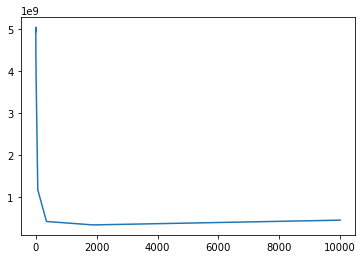

In [90]:
lambdaCV.mean(axis=1).plot()

In [91]:
l = optimal_lambda.index[0].item()

In [92]:
final_pipe_lasso = make_pipeline(
            preprocessor,
            PolynomialFeatures(degree=3, include_bias=False),
            StandardScaler(with_mean=False),
            Lasso(alpha = l, random_state=1, max_iter  = 10000)
)

model = final_pipe_lasso.fit(X_dev, y_dev)

In [93]:
y_hat  = model.predict(X_test)

In [94]:
pd.DataFrame({
    'y hat': y_hat,
    'Sand': y_test
})


,y hat,Sand
67,10687.641578,8659.726496
86,24373.282257,20241.681034
83,22167.097308,17229.800000
44,19079.891933,19884.040000
29,69507.926145,30672.959184
27,56881.808862,180672.714912
75,17814.796903,17311.649573
14,30039.552125,26354.601399
79,21268.346289,16915.673267
82,21947.331403,16531.148936


In [95]:
X_dev_transformed = preprocessor.fit_transform(X_dev)
poly_features = model.named_steps['polynomialfeatures']

poly_features.fit(X_dev_transformed)
transformed_feature_names = preprocessor.get_feature_names_out()  # Fra version 0.24 af scikit-learn.
polynomial_feature_names = poly_features.get_feature_names(input_features=transformed_feature_names)

polynomial_feature_names


lasso_coefs = model.named_steps['lasso'].coef_
feature_coefficients = dict(zip(polynomial_feature_names, lasso_coefs))

for feature, coef in feature_coefficients.items():
    if coef > 0:
        print(f"{feature}: {coef}")

# preprocessor.fit(X_dev)

len(lasso_coefs)

# feature_names = preprocessor.get_feature_names_out()
# poly_features.fit(X_dev_transformed)
# lasso_coefs = model.named_steps['lasso'].coef_
# feature_coefficients = dict(zip(feature_names, lasso_coefs))

# for feature, coef in feature_coefficients.items():
#     print(f"{feature}: {coef}")

onehotencoder__housing_type_Ejerlejlighed: 2800.936810099075
standardscaler__erhvervsindkomst: 6223.574206462381
onehotencoder__housing_type_Ejerlejlighed^2: 484.4948991906914
onehotencoder__housing_type_Ejerlejlighed standardscaler__erhvervsindkomst: 2840.5642680863116
onehotencoder__housing_type_Ejerlejlighed standardscaler__formueindkomst: 155.5314120844793
onehotencoder__housing_type_Ejerlejlighed^3: 33.183877082864576
onehotencoder__housing_type_Ejerlejlighed^2 standardscaler__erhvervsindkomst: 824.6741059350126
onehotencoder__housing_type_Ejerlejlighed^2 standardscaler__formueindkomst: 25.46681051213506
onehotencoder__housing_type_Ejerlejlighed standardscaler__kont_recip_tot standardscaler__gini_index: 2641.3906688957177
onehotencoder__housing_type_Ejerlejlighed standardscaler__gini_index^2: 5010.48240460075


c:\program files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


164

Nå. Det er altsammen meget godt. Hvordan med elasticnet?

In [104]:
from sklearn.compose import ColumnTransformer

# categorical_features = ['housing_type'] # piller som test år og muni_code ud
# numeric_features = ['erhvervsindkomst', 'formueindkomst', 'anden_personlig_indkomst', "kont_recip_tot", "gini_index" ]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('polynomial', PolynomialFeatures(degree=3)),  # Tilføj denne linje
    ('classifier', ElasticNet())
])

param_grid = {
    'polynomial__degree': [1, 2, 3],  # Ny linje for at prøve forskellige polynomial grader
    'classifier__alpha': np.logspace(-4, 4, 12),
    'classifier__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

#[0.001, 0.01, 0.1, 1, 10, 100]
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
print(best_parameters)

best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.240e+09, tolerance: 1.618e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.843e+09, tolerance: 1.384e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.793e+09, tolerance: 1.460e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.414e+09, tolerance: 7.595e+05
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.532e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.501e+08, tolerance: 1.460e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.796e+07, tolerance: 7.595e+05
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.140e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.611e+06, tolerance: 1.460e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e+06, tolerance: 7.595e+05
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e+07, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.790e+09, tolerance: 1.460e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e+09, tolerance: 7.595e+05
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.528e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.655e+08, tolerance: 1.384e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.074e+08, tolerance: 1.460e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.278e+07, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e+08, tolerance: 1.364e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.234e+09, tolerance: 1.618e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.836e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.413e+09, tolerance: 7.595e+05
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+09, tolerance: 1.364e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.041e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.179e+09, tolerance: 1.364e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.743e+07, tolerance: 1.618e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.490e+07, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+06, tolerance: 7.595e+05
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.541e+07, tolerance: 1.364e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.231e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.687e+08, tolerance: 1.618e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e+08, tolerance: 1.384e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e+09, tolerance: 1.618e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.870e+08, tolerance: 1.384e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.374e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.056e+08, tolerance: 1.384e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.314e+08, tolerance: 1.460e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.500e+07, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.743e+09, tolerance: 1.618e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.337e+09, tolerance: 1.384e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.457e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.651e+08, tolerance: 1.618e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.655e+08, tolerance: 1.384e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.074e+08, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.128e+09, tolerance: 1.364e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e+09, tolerance: 1.618e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.343e+08, tolerance: 1.618e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.659e+08, tolerance: 1.384e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.643e+08, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+09, tolerance: 1.618e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.198e+08, tolerance: 1.384e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.294e+07, tolerance: 7.595e+05
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.117e+09, tolerance: 1.364e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.556e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.297e+08, tolerance: 7.595e+05
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e+09, tolerance: 1.364e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.419e+07, tolerance: 1.384e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.347e+09, tolerance: 1.618e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.790e+08, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e+06, tolerance: 1.460e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.950e+05, tolerance: 7.595e+05
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e+06, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.786e+09, tolerance: 1.364e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.029e+09, tolerance: 1.618e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.255e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.261e+08, tolerance: 7.595e+05
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.235e+09, tolerance: 1.364e+06
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e+09, to

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.592e+09, tolerance: 1.618e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.010e+09, tolerance: 1.384e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.582e+09, tolerance: 1.384e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.020e+09, tolerance: 1.460e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.690e+09, tolerance: 1.364e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.079e+09, tolerance: 1.618e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.780e+09, tolerance: 7.595e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.794e+09, tolerance: 1.364e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.874e+09, tolerance: 1.384e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\program files\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.267e+09, tolerance: 1.460e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

{'classifier__alpha': 1873.8174228603868, 'classifier__l1_ratio': 1, 'polynomial__degree': 1}


In [109]:
pd.DataFrame({"predicted":y_pred, "sand": y_test})

,predicted,sand
67,9945.217551,8659.726496
86,28170.270722,20241.681034
83,26333.535868,17229.800000
44,19020.446726,19884.040000
29,45293.139006,30672.959184
27,40701.138573,180672.714912
75,19020.446726,17311.649573
14,30911.455008,26354.601399
79,23765.599502,16915.673267
82,25373.574670,16531.148936


In [ ]:
# LOAD FROM SCIKIT-LEARN
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lasso,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=10)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

mse_.head(5)